In [8]:
!pip install -Uqq fastai

In [9]:
from fastcore.all import *
import time

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

In [10]:
urls = search_images('photo of apple', max_images=1)
urls[0]

'https://images.pexels.com/photos/693794/pexels-photo-693794.jpeg?cs=srgb&dl=green-apple-lot-693794.jpg&fm=jpg'

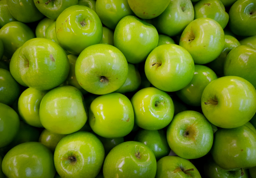

In [11]:
from fastdownload import download_url
dest = 'apple.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

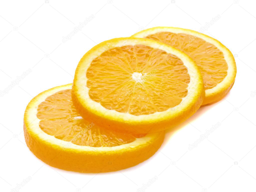

In [12]:
download_url(search_images('photo of orange', max_images=1)[0], 'orange.jpg', show_progress=False)
Image.open('orange.jpg').to_thumb(256,256)

In [13]:
searches = 'photo of apple','photo of orange'
path = Path('apple or orange?')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=200, dest=path/o)

In [14]:
print(path)

apple or orange?


In [15]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

13

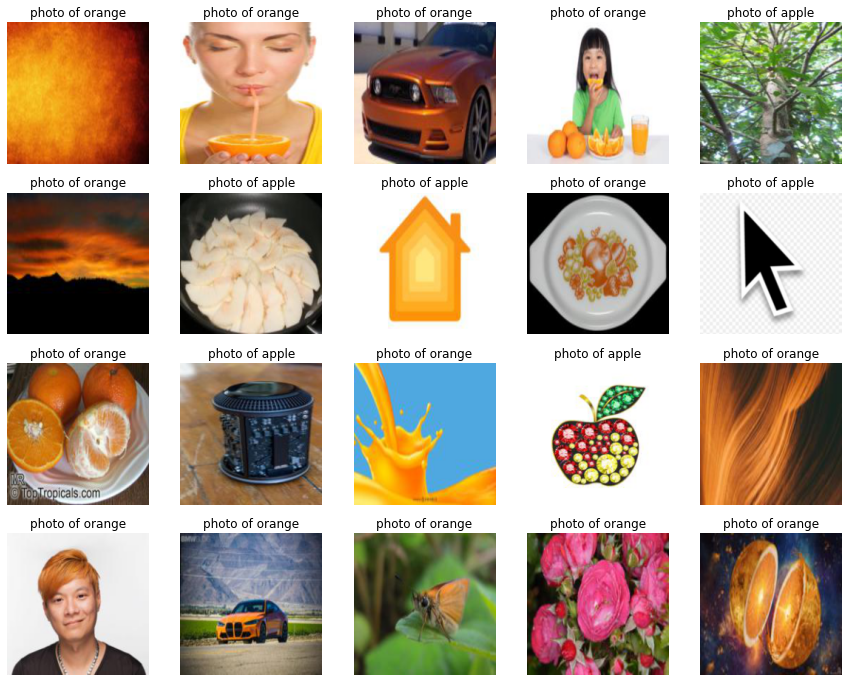

In [16]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=20)

In [17]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(30)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.018449,1.919398,0.478261,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.716189,1.060101,0.362319,00:02
1,0.600854,0.695925,0.333333,00:01
2,0.491784,0.596968,0.260870,00:01
3,0.403276,0.606077,0.260870,00:01
4,0.330928,0.617245,0.231884,00:01
5,0.272884,0.614121,0.231884,00:01
6,0.231856,0.648071,0.231884,00:01
7,0.199135,0.654495,0.246377,00:01
8,0.170583,0.633515,0.231884,00:02
9,0.147475,0.635889,0.217391,00:01


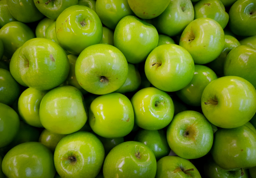

In [18]:
download_url(search_images('photo of apple', max_images=1)[0], 'apple.jpg', show_progress=False)
Image.open('apple.jpg').to_thumb(256,256)

In [20]:
is_normal,_,probs = learn.predict(PILImage.create('apple.jpg'))
print(f"This is a: {is_normal}.")
print(f"Probability it's an apple: {probs[0]:.4f}")

This is a: photo of apple.
Probability it's an apple: 1.0000


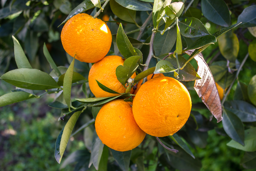

In [24]:
download_url(search_images('oranges', max_images=1)[0], 'orange.jpg', show_progress=False)
Image.open('orange.jpg').to_thumb(256,256)

In [25]:
is_normal,_,probs = learn.predict(PILImage.create('orange.jpg'))
print(f"This is a: {is_normal}.")
print(f"Probability it's apple: {probs[0]:.4f}")

This is a: photo of orange.
Probability it's apple: 0.0012
